In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
!cat dispCDF40_ver4.2.in.txt

length	width	depth	strike	dip	rake	slip	lat	long
50.0    50.0    0.0     193.0   14.0     81.0   0.00   39.738   144.331  # E01
50.0    50.0    0.0     193.0   14.0     81.0   0.00   39.3     144.20   # E02
50.0    50.0    0.0     193.0   14.0     81.0   5.66   38.862   144.069  # E03
50.0    50.0    0.0     193.0   14.0     81.0  41.15   38.424   143.939  # E04
50.0    50.0    0.0     193.0   14.0     81.0  47.93   37.986   143.810  # E05
50.0    50.0    0.0     193.0   14.0     81.0   8.44   37.547   143.682  # E06
50.0    50.0    0.0     193.0   14.0     81.0   0.00   37.135   143.40   # E07
50.0    50.0    0.0     193.0   14.0     81.0   0.00   36.730   143.07   # E08
50.0    50.0    0.0     193.0   14.0     81.0   1.89   36.325   142.74   # E09
50.0    50.0    0.0     193.0   14.0     81.0   0.63   35.905   142.504  # E10
50.0    50.0   12.1     193.0   14.0     81.0   0.00   39.836   143.778  # E11
50.0    50.0   12.1     193.0   14.0     81.0   0.81   39.398   143.651  # E12
50.

In [4]:
df = pd.read_csv('dispCDF40_ver4.2.in.txt', delim_whitespace=True, comment='#')

df = df.rename(columns={
    'length': 'L',
    'width': 'W',
    'long': 'lon'
})

df['L'] = 1000*df['L']
df['W'] = 1000*df['W']
df['depth'] *=1000
df['reference'] = 'center'
df.head()

,L,W,depth,strike,dip,rake,slip,lat,lon,reference
0,50000.0,50000.0,0.0,193.0,14.0,81.0,0.00,39.738,144.331,center
1,50000.0,50000.0,0.0,193.0,14.0,81.0,0.00,39.300,144.200,center
2,50000.0,50000.0,0.0,193.0,14.0,81.0,5.66,38.862,144.069,center
3,50000.0,50000.0,0.0,193.0,14.0,81.0,41.15,38.424,143.939,center
4,50000.0,50000.0,0.0,193.0,14.0,81.0,47.93,37.986,143.810,center


In [5]:
df = pd.read_csv('usgs.txt', delim_whitespace=True)
df = df.rename(columns={
    'Lat.': 'lat',
    'Lon.': 'lon'
})
df['L'] = 25000
df['W'] = 16600
df['slip'] *= 0.01
df['depth'] *= 1000
df['reference'] = 'center'
print(df['slip'].min(),df['slip'].max())
print(df['depth'].min(),df['depth'].max())

df.head()

0.0006168 55.0268701
2932.7 50815.9


,lat,lon,depth,slip,rake,strike,dip,t_rup,t_ris,t_fal,mo,L,W,reference
0,40.6019,143.72940,15193.4,0.573538,117.14320,198.0,15.0,148.0,6.4,4.8,9.758958e+25,25000,16600,center
1,40.3879,143.64079,15193.4,1.410308,87.10259,198.0,15.0,140.0,8.0,14.4,2.399689e+26,25000,16600,center
2,40.1740,143.55220,15193.4,0.349885,83.75771,198.0,15.0,128.0,19.2,1.6,5.953423e+25,25000,16600,center
3,39.9600,143.46359,15193.4,2.199107,101.95310,198.0,15.0,100.0,8.0,17.6,3.741859e+26,25000,16600,center
4,39.7460,143.37500,15193.4,5.213699,92.39947,198.0,15.0,76.0,9.6,1.6,8.871303e+26,25000,16600,center


In [6]:
df.to_csv('earthquake.csv',index=False)

# Geoclaw

In [7]:
from clawpack.geoclaw import dtopotools

In [8]:
fault = dtopotools.Fault()
fault.subfaults = []
df.loc[0,'lat']

for index, row in df.iterrows():
#     row = df.loc[0]
    usgs_subfault = dtopotools.SubFault()
    usgs_subfault.latitude = row['lat']
    usgs_subfault.longitude = row['lon']
    usgs_subfault.depth = row['depth']
    usgs_subfault.slip = row['slip']
    usgs_subfault.strike = row['strike']
    usgs_subfault.dip = row['dip']
    usgs_subfault.rake = row['rake']
    usgs_subfault.length = row['L']
    usgs_subfault.width = row['W']
    usgs_subfault.coordinate_specification = 'centroid'
    fault.subfaults.append(usgs_subfault)

In [9]:
fault.Mw()

9.0677902063334912

In [10]:
x = np.linspace(139,146,360)
y = np.linspace(35,41,361)
# x = np.linspace(-120,-60,361)
# y = np.linspace(-60,0,361)

times = [1.]
fault.create_dtopography(x,y,times)

In [11]:
dtopo_fname='usgs.tt3'
fault.dtopo.write(dtopo_fname, dtopo_type=3)

Created  usgs.png


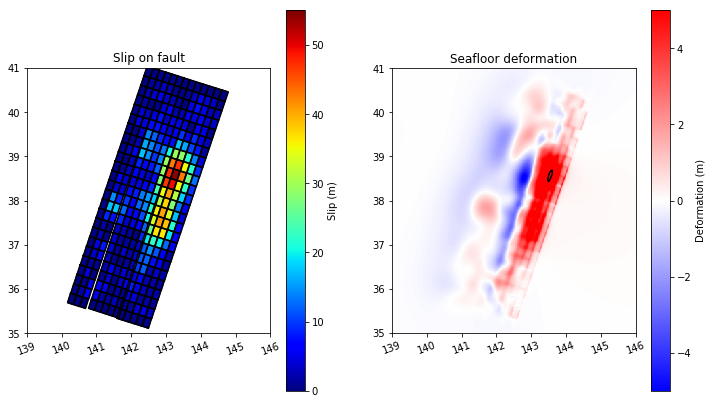

In [12]:
import os
plt.figure(figsize=(12,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(139,146)
ax1.set_ylim(35,41)
ax2.set_xlim(139,146)
ax2.set_ylim(35,41)
fault.dtopo.plot_dZ_colors(1.,axes=ax2, cmax_dZ=5.0, dZ_interval=10)
fname = os.path.splitext(os.path.split(dtopo_fname)[-1])[0] + '.png'
plt.savefig(fname)
print("Created ",fname)


(35, 41)

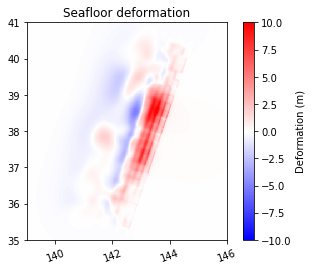

In [13]:
fault.dtopo.plot_dZ_colors(1.0, cmax_dZ=10.0, dZ_interval=100)
plt.gca().set_xlim(139,146)
plt.gca().set_ylim(35,41)

# Easywave

In [14]:
df['reference']='C'
df['depth'] /=1000
df['L'] /=1000
df['W'] /=1000

In [15]:
f = open('fault.flt','w')

for index, row in df.iterrows():
    rowString = '-location {lon} {lat} {depth} -refpos {reference} -strike {strike} -dip {dip} -rake {rake} -slip {slip} -size {L} {W}\n'
    rowString = rowString.format(**row)
    f.write(rowString)

f.close()